In [3]:
import pandas as pd
import numpy as np
import json
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

def load_and_combine_datasets(input_folder, filenames):
    combined_df = pd.DataFrame()
    for filename in filenames:
        csv_file_path = os.path.join(input_folder, filename)
        df = pd.read_csv(csv_file_path)
        df['region'] = filename.split('.')[0].split('_')[0]  # Add a column to track the origin region
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

def split_and_save_datasets(combined_df, output_folder):
    for region in combined_df['region'].unique():
        region_df = combined_df[combined_df['region'] == region].copy()  # Create a copy to avoid SettingWithCopyWarning
        if 'area' in region_df.columns:  # Check if 'area' column exists
            region_df.drop('area', axis=1, inplace=True)  # Drop the 'area' column
        # Ensure 'region' is the last column
        region_col = region_df['region']  # Temporarily save the 'region' column
        region_df.drop('region', axis=1, inplace=True)  # Drop the 'region' column to re-add it later
        region_df['region'] = region_col  # Re-add 'region' column to ensure it's the last column

        region_df = region_df.sample(frac=1, random_state=42)
        region_df.to_csv(os.path.join(output_folder, f"{region}.csv"), index=False)

def load_geojson(geojson_path, attribute_name):
    with open(geojson_path) as f:
        data = json.load(f)
    return {feature['properties']['id']: feature['properties'][attribute_name] for feature in data['features']}

def add_geojson_attribute_to_df(df, geojson_data, attribute_name):
    df[attribute_name] = df['id'].map(geojson_data)
    # Debug: Print types of each column
    print("Types after adding GeoJSON attribute:", df.dtypes)
    return df

def calculate_mode_with_kde(df, attribute_name):
    modes = {}
    for class_id in df['classid'].unique():
        attribute_values = df[df['classid'] == class_id][attribute_name].values
        if len(attribute_values) > 0:
            kde = gaussian_kde(attribute_values)
            x_grid = np.linspace(min(attribute_values), max(attribute_values), 1000)
            kde_estimates = kde.evaluate(x_grid)
            mode_index = np.argmax(kde_estimates)
            modes[class_id] = x_grid[mode_index]
    return modes

def verification_and_plotting(original_df, resampled_df, attribute_name, modes, output_folder, seed=42, bins=500, x_axis_range=(0, 15000)):
    output_path = os.path.join(output_folder, 'plots')
    os.makedirs(output_path, exist_ok=True)
    
    class_name_mapping = {
        0: "Barley",
        1: "Wheat",
        2: "Corn",
        3: "Fodder",
        4: "Fallow",
        5: "Miscellaneous",
        6: "Orchards",
        7: "Cereals",
        8: "Permanent Meadows",
        9: "Protein Crops",
        10: "Rapeseed",
        11: "Temporary Meadows",
        12: "Vegetables"
    }
    
    print("\nVerifying Total Samples Per Class Before and After Resampling:")
    classes = original_df['classid'].unique()
    
    for class_id, mode in modes.items():
        class_name = class_name_mapping.get(class_id, f"Unknown Class {class_id}")
        
        original_df_class = original_df[original_df['classid'] == class_id]
        resampled_df_class = resampled_df[resampled_df['classid'] == class_id]
        
        below_mode_percentage_original = len(original_df_class[original_df_class[attribute_name] < mode]) / len(original_df_class) * 100
        below_mode_percentage_resampled = len(resampled_df_class[resampled_df_class[attribute_name] < mode]) / len(resampled_df_class) * 100
        
        original_count = len(original_df_class)
        resampled_count = len(resampled_df_class)
        
        print(f"Class {class_id}: Before = {original_count}, After = {resampled_count}")
        print(f"Class {class_id}: Mode = {mode:.2f}, Before Resampling: Below mode = {below_mode_percentage_original:.2f}%, After Resampling: Below mode = {below_mode_percentage_resampled:.2f}%")

        plt.figure(figsize=(12, 8))

        max_count = 0
        for df in [original_df_class, resampled_df_class]:
            counts, _, _ = plt.hist(df[attribute_name], bins=bins, range=x_axis_range)
            plt.close()
            max_count = max(max_count, max(counts))
        
        plt.figure(figsize=(12, 8))

        for i, df in enumerate([original_df_class, resampled_df_class], start=1):
            ax1 = plt.subplot(1, 2, i)
            ax1.hist(df[attribute_name], bins=bins, range=x_axis_range, color='blue' if i == 1 else 'green', alpha=0.5, label='Count')
            
            ax1.set_ylim(0, max_count*1.2)
            ax1.set_xlabel(attribute_name)
            ax1.set_ylabel('Count')
            ax1.axvline(mode, color='red', linestyle='--', label='Mode')
            ax1.set_xlim(x_axis_range)
            ax1.legend(loc='upper left')
            ax1.set_title(f"{class_name} {'Before' if i == 1 else 'After'} Resampling")
            
            ax2 = ax1.twinx()
            sns.kdeplot(df[attribute_name], ax=ax2, color='red', alpha=0.7, label='Density')
            ax2.set_ylabel('Density')
            ax2.grid(False)
            ax2.legend(loc='upper right')

        plt.figtext(0.5, 0.01, f'Below mode: Before = {below_mode_percentage_original:.2f}%, After = {below_mode_percentage_resampled:.2f}%  Class {class_id}: Before = {original_count}, After = {resampled_count}', wrap=True, horizontalalignment='center', fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        file_path = os.path.join(output_path, f'{class_name}_plot.png')
        
        plt.savefig(file_path)
        plt.show()
        plt.close()

        print(f"Plot saved to {file_path}")

def resample(df, modes, attribute_name, desired_ratio, skip_classids, seed=42):
    np.random.seed(seed)

    df_resampled = pd.DataFrame()
    
    for class_id, mode in modes.items():
        df_class = df[df['classid'] == class_id]

        if class_id in skip_classids:
            df_resampled = pd.concat([df_resampled, df_class])
            continue

        below_mode = df_class[df_class[attribute_name] < mode]
        above_mode = df_class[df_class[attribute_name] >= mode]
        
        total = len(below_mode) + len(above_mode)
        target_below = int(total * desired_ratio[0] / sum(desired_ratio))
        target_above = total - target_below

        # Handling duplicates in above_mode
        met_target_with_duplicates = False
        if len(above_mode) > target_above:
            all_duplicates = above_mode.duplicated(subset='id', keep='first')
            excess_duplicates = above_mode[all_duplicates]
            
            if len(excess_duplicates) < (len(above_mode) - target_above):
                df_class = df_class.drop(excess_duplicates.index)
            else:
                samples_to_drop = excess_duplicates.sample(n=(len(above_mode) - target_above), random_state=seed)
                df_class = df_class.drop(samples_to_drop.index)
                met_target_with_duplicates = True

        if not met_target_with_duplicates:
            total = len(df_class)
            below_mode = df_class[df_class[attribute_name] < mode]
            above_mode = df_class[df_class[attribute_name] >= mode]
            target_below = int((desired_ratio[0] / desired_ratio[1]) * len(above_mode))

        
        if len(below_mode) < target_below:
            below_mode = df_class[df_class[attribute_name] < mode]
            distances = mode - below_mode[attribute_name]
            weights = distances ** 2
            weights /= weights.sum()
            
            adjustment_count = target_below - len(below_mode)
            extra_samples = below_mode.sample(n=adjustment_count, replace=True, weights=weights, random_state=seed)
            df_class = pd.concat([df_class, extra_samples])

        df_resampled = pd.concat([df_resampled, df_class])
        
    # Random oversampling to balance class distribution
    max_class_size = df_resampled['classid'].value_counts().max()
    for class_id in df_resampled['classid'].unique():
        class_subset = df_resampled[df_resampled['classid'] == class_id]
        samples_to_add = max_class_size - class_subset.shape[0]
        if samples_to_add > 0:
            oversampled_subset = class_subset.sample(n=samples_to_add, replace=True, random_state=seed)
            df_resampled = pd.concat([df_resampled, oversampled_subset])
            
    df_resampled['path'] = df_resampled['path'].astype(str)
    #df_resampled['path'] = df_resampled['path'].astype(object)

    return df_resampled

def analyze_resampling_efficiency(input_folder, output_folder, file_prefixes=['frh01', 'frh02', 'frh03']):
    def read_and_concatenate(folder):
        dfs = []
        for prefix in file_prefixes:
            file_path = os.path.join(folder, f"{prefix}.csv")
            df = pd.read_csv(file_path)
            dfs.append(df)
        return pd.concat(dfs, ignore_index=True)

    before_df = read_and_concatenate(input_folder)
    after_df = read_and_concatenate(output_folder)
    
    unique_ids_before = before_df['id'].nunique()
    unique_ids_after = after_df['id'].nunique()
    
    total_occurrences_before = before_df.shape[0]
    total_occurrences_after = after_df.shape[0]
    
    avg_occurrences_per_id_before = total_occurrences_before / unique_ids_before
    avg_occurrences_per_id_after = total_occurrences_after / unique_ids_after
    
    print(f"Total unique IDs before resampling: {unique_ids_before}")
    print(f"Total unique IDs after resampling: {unique_ids_after}")
    print(f"Average occurrences per ID before resampling: {avg_occurrences_per_id_before:.2f}")
    print(f"Average occurrences per ID after resampling: {avg_occurrences_per_id_after:.2f}")
    
    if unique_ids_after >= unique_ids_before:
        print("The resampling process has maintained or increased the diversity of unique IDs.")
    else:
        print("The resampling process has decreased the diversity of unique IDs.")
        
    if avg_occurrences_per_id_after < avg_occurrences_per_id_before:
        print("The resampling process has efficiently reduced duplicate IDs.")
    else:
        print("The resampling process may not have efficiently reduced duplicate IDs.")


def ROR(input_folder, output_folder, geojson_path, attribute_name, skip_classids, desired_ratio=(0.35, 0.65), seed=42, bins=100):
    geojson_data = load_geojson(geojson_path, attribute_name)
    os.makedirs(output_folder, exist_ok=True)
    
    # Copy validation files directly
    for region in ['frh01', 'frh02', 'frh03']:
        val_file_path = os.path.join(input_folder, f'{region}_val.csv')
        shutil.copy(val_file_path, os.path.join(output_folder, f'{region}_val.csv'))
    
    filenames = ['frh01.csv', 'frh02.csv', 'frh03.csv']
    combined_df = load_and_combine_datasets(input_folder, filenames)
    combined_df = add_geojson_attribute_to_df(combined_df, geojson_data, attribute_name)
    
    df_train = combined_df.copy()
    
    modes = calculate_mode_with_kde(df_train, attribute_name)
    df_train_resampled = resample(df_train, modes, attribute_name, desired_ratio, skip_classids, seed)
    
    # Handle idx values for duplicates
    duplicate_id_prefix = '9999999'
    duplicate_id_counter = 0
    
    df_train_resampled['idx'] = df_train_resampled['idx'].astype(str)
    duplicate_map = {}
    for index, row in df_train_resampled.iterrows():
        if row['id'] in duplicate_map:
            new_idx = int(f"{duplicate_id_prefix}{duplicate_map[row['id']]}")
            df_train_resampled.at[index, 'idx'] = new_idx
            duplicate_map[row['id']] += 1
        else:
            duplicate_map[row['id']] = 1
    
    df_train_resampled['idx'] = df_train_resampled['idx'].astype(int)  # Convert idx back to int if necessary
    
    combined_df_resampled = pd.concat([df_train_resampled], ignore_index=True)
    
    # Force path column to be of type str
    combined_df_resampled['path'] = combined_df_resampled['path'].astype(str)
    
    # Debug: Check types and sample rows of combined_df_resampled
    print("Types in combined_df_resampled after concatenation:", combined_df_resampled.dtypes)
    print("Sample rows in combined_df_resampled after concatenation:")
    print(combined_df_resampled.head())

    verification_and_plotting(df_train, df_train_resampled, attribute_name, modes, output_folder, seed, bins=100)
    
    split_and_save_datasets(combined_df_resampled, output_folder)
    shutil.copy(os.path.join(input_folder, 'frh04.csv'), os.path.join(output_folder, 'frh04.csv'))
    
    analyze_resampling_efficiency(input_folder, output_folder)


Types after adding GeoJSON attribute: idx                 int64
id                  int64
CODE_CULTU         object
path               object
meanCLD           float64
sequencelength      int64
classid             int64
classname          object
region             object
area              float64
dtype: object
Types in combined_df_resampled after concatenation: idx                 int64
id                  int64
CODE_CULTU         object
path               object
meanCLD           float64
sequencelength      int64
classid             int64
classname          object
region             object
area              float64
dtype: object
Sample rows in combined_df_resampled after concatenation:
      idx       id CODE_CULTU                   path     meanCLD  \
0   48580  1982344        J6S  csv/frh01/1982344.csv  714.151888   
1  214232  2151679        J5M  csv/frh01/2151679.csv  741.638294   
2   32178  1965735        J5M  csv/frh01/1965735.csv  731.100161   
3   65371  1999574        J6S  c

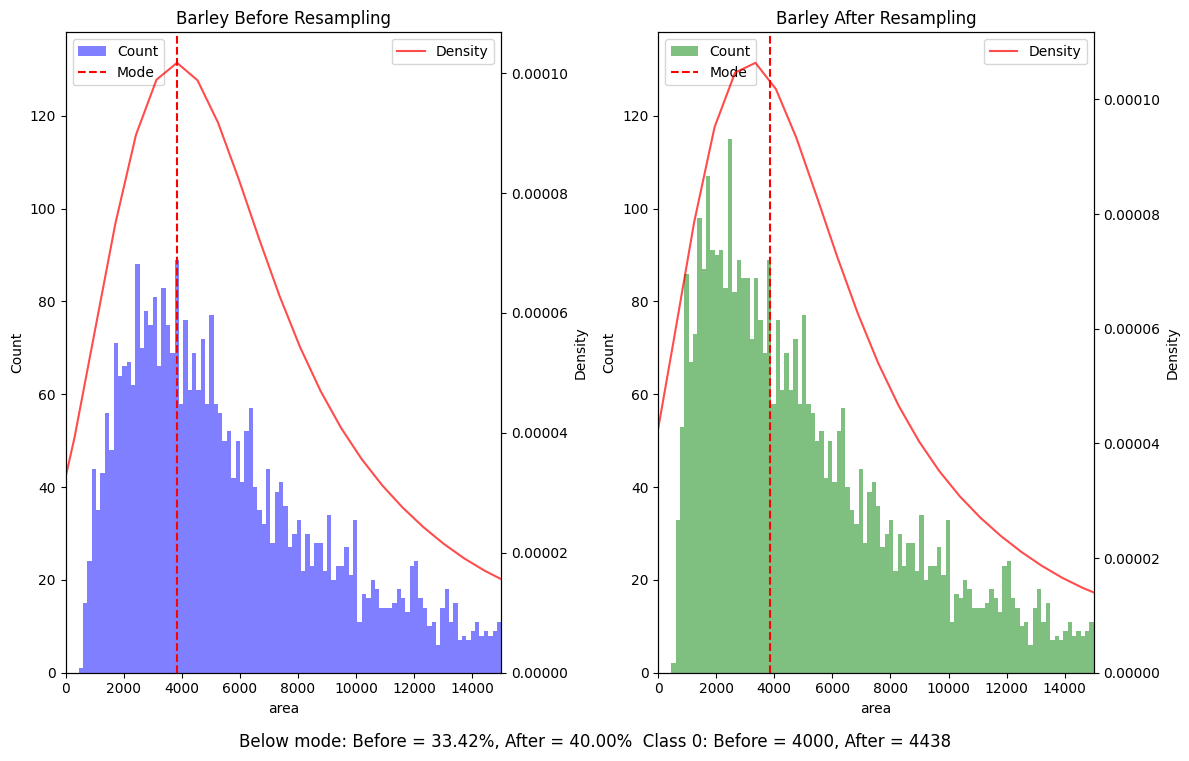

Plot saved to main/TEST-RO-R-40/plots/Barley_plot.png
Class 1: Before = 4000, After = 4438
Class 1: Mode = 2457.95, Before Resampling: Below mode = 39.40%, After Resampling: Below mode = 40.22%


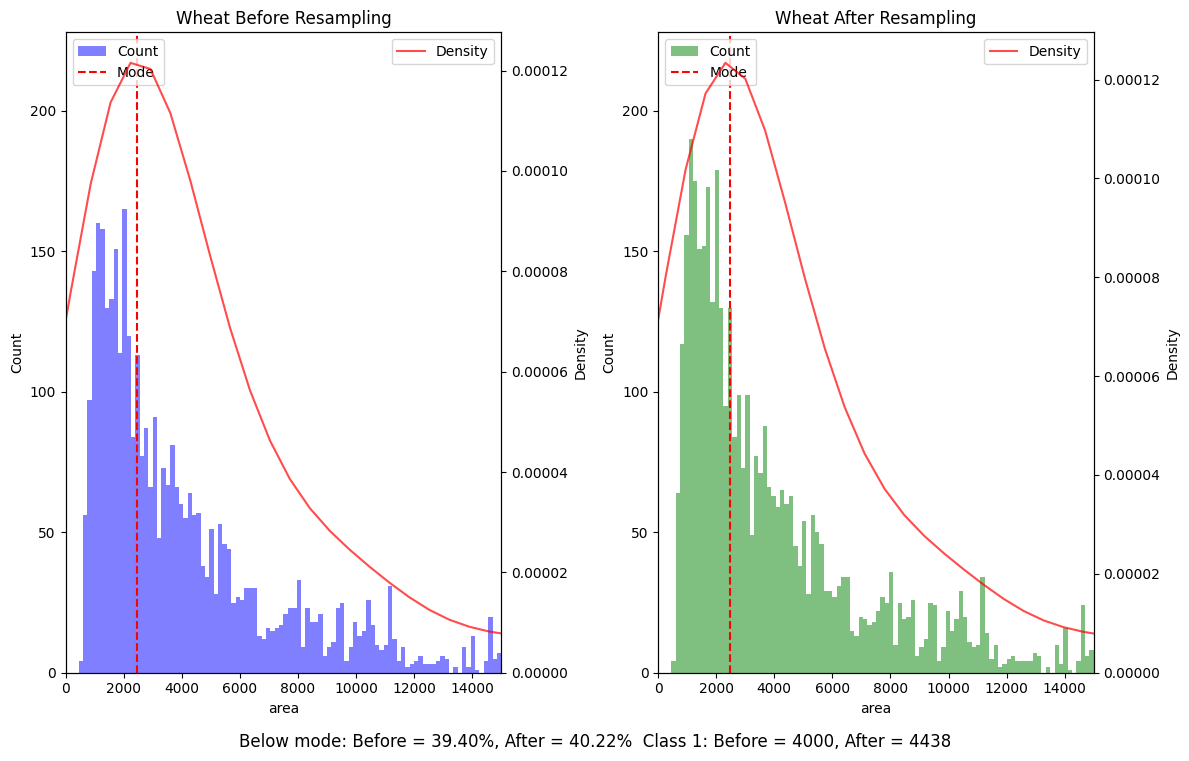

Plot saved to main/TEST-RO-R-40/plots/Wheat_plot.png
Class 2: Before = 4000, After = 4438
Class 2: Mode = 11159.71, Before Resampling: Below mode = 25.60%, After Resampling: Below mode = 39.86%


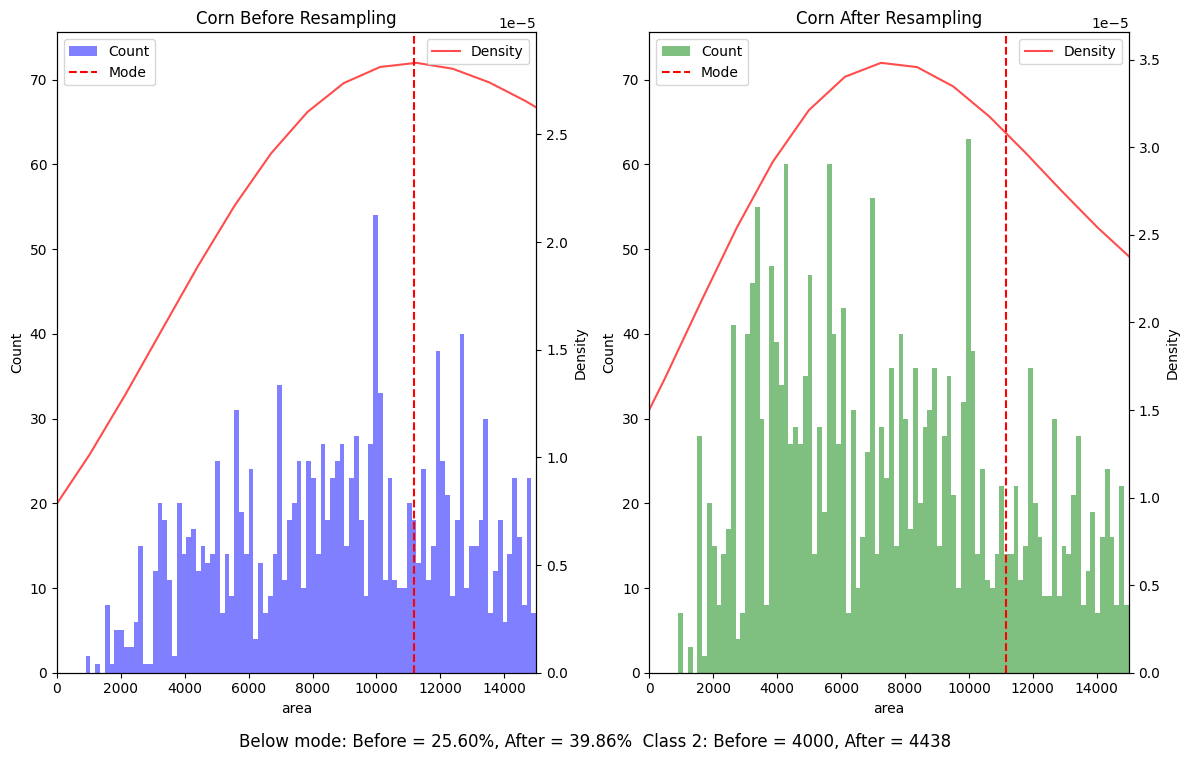

Plot saved to main/TEST-RO-R-40/plots/Corn_plot.png
Class 3: Before = 4000, After = 4438
Class 3: Mode = 14562.60, Before Resampling: Below mode = 26.52%, After Resampling: Below mode = 40.02%


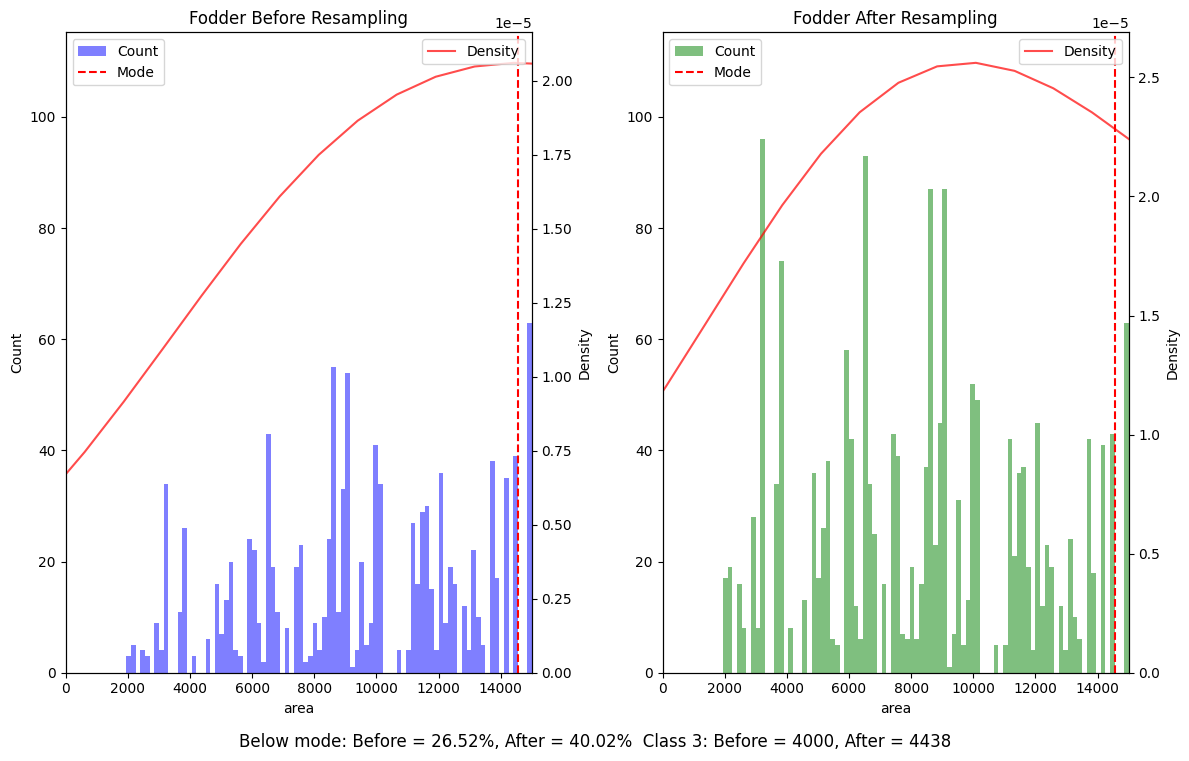

Plot saved to main/TEST-RO-R-40/plots/Fodder_plot.png
Total unique IDs before resampling: 8399
Total unique IDs after resampling: 8399
Average occurrences per ID before resampling: 1.90
Average occurrences per ID after resampling: 2.11
The resampling process has maintained or increased the diversity of unique IDs.
The resampling process may not have efficiently reduced duplicate IDs.


In [4]:
# Example usage
skip_classids = []
input_folder = 'main/1-RO'  # Replace with your input folder path
output_folder = 'main/1-RO-R-40'  # Replace with your desired output folder path
geojson_path = '/data/private/BreizhCrops/data/all_parcels.geojson'
ROR(input_folder, output_folder, geojson_path, 'area', skip_classids, desired_ratio=(0.4, 0.6))